In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib as jb

%matplotlib inline

In [46]:
alphabets = {
    1: 'A',
    2: 'B',
    3: 'C',
    4: 'D',
    5: 'E',
    6: 'F',
    7: 'G',
    8: 'H',
    9: 'I',
    10: 'J',
    11: 'K',
    12: 'L',
    13: 'M',
    14: 'N',
    15: 'O',
    16: 'P',
    17: 'Q',
    18: 'R',
    19: 'S',
    20: 'T',
    21: 'U',
    22: 'V',
    23: 'W',
    24: 'X',
    25: 'Y',
    26: 'Z'
}

In [47]:
def resize_img(image):
    (h,w,d) = image.shape
    # ratio = h/w
    ratio = 295/1599
    nw = 800
    nh = int(nw*ratio)
    
    return (nw, nh)

In [48]:
img = cv2.imread('sample.jpeg')
dimens = resize_img(img)
img = cv2.resize(img, dimens)

<Figure size 640x480 with 0 Axes>

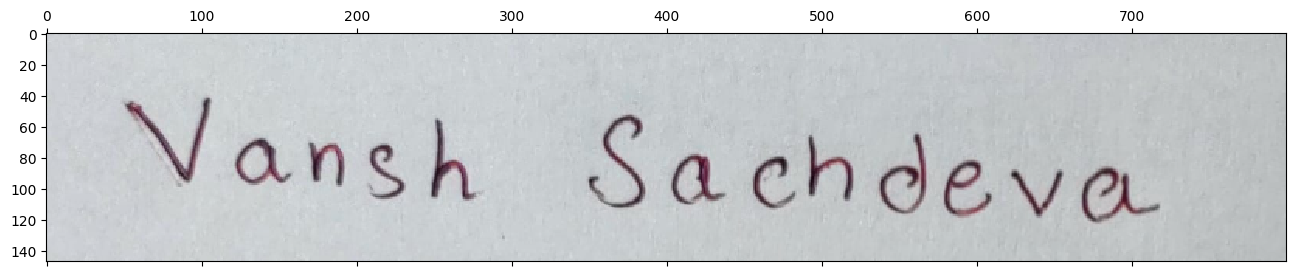

In [49]:
plt.gray()
plt.matshow(img)

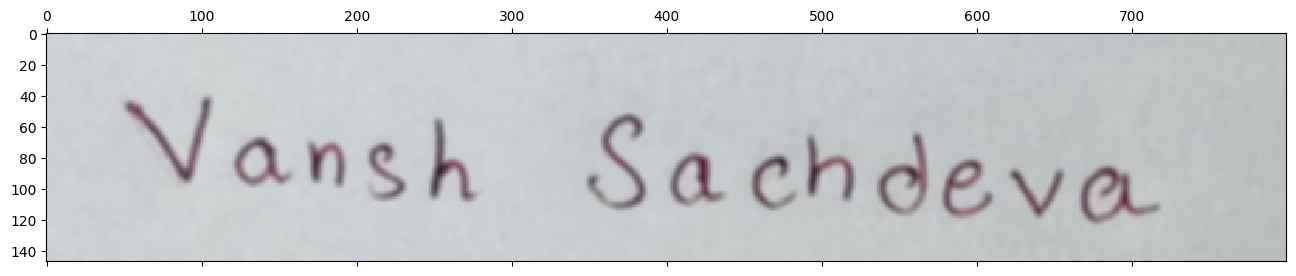

In [50]:
blur = cv2.GaussianBlur(img, (5,5), 10)

plt.matshow(blur)

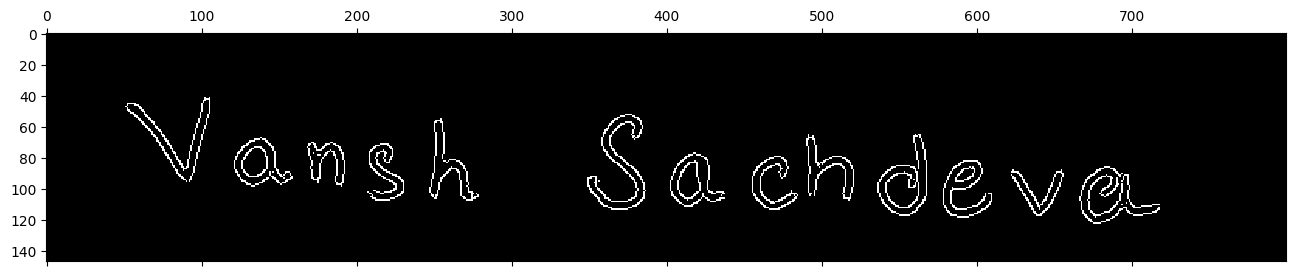

In [51]:
edged = cv2.Canny(blur, 80, 100)

plt.matshow(edged)

In [52]:
model = jb.load('model')

def recognize(arr):
    gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (28,28))
    transposed = np.transpose(resized)
    bnw = cv2.threshold(transposed, 128, 255, cv2.THRESH_BINARY)[1]
    bnw_inv = cv2.bitwise_not(bnw, bnw)
    final = bnw_inv.reshape(784)

    prediction = model.predict([final])[0]
    return alphabets[prediction]

In [53]:
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [54]:
img_copy = img.copy()

for c in contours:
    (x,y,w,h) = cv2.boundingRect(c)
    # if w>=15 and h>=15:
    if w>=20 and h>=29:
        cv2.rectangle(img_copy, (x-5,y-5), (x+w+5, y+h+5), (0,255,0), 2)
        input = img[y-10:y+h+10, x-10:x+w+10]
        prediction = recognize(input)
        cv2.putText(img_copy, prediction, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

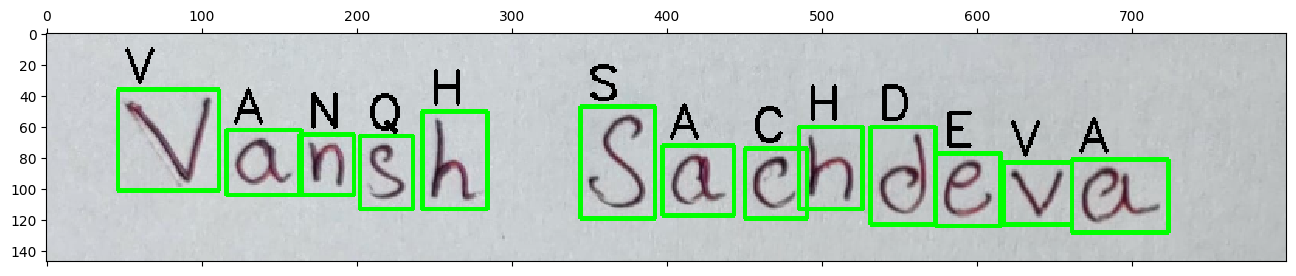

In [55]:
plt.matshow(img_copy)